# Análise do campo de ML por desenvolvimento do país

Machine Learning uma das área mais emergentes na computação, e diversas técnicas exigem amplo poder computacional. Queremos então estudar como a diferença no desenvolvimento de países, separados em desenvolvidos e emergentes, impactam nessa área - inclusive para o mercado de trabalho.

In [244]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth
import pysubgroup as ps
import numpy as np

np.seterr(divide='ignore', invalid='ignore')

df = pd.read_csv('./data/processed.csv')
df.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_Coursera,Q6_edX,Q6_Kaggle Learn Courses,Q6_DataCamp,Q6_Fast.ai,...,Q44_Twitter (data science influencers),"Q44_Email newsletters (Data Elixir, O'Reilly Data & AI, etc)","Q44_Reddit (r/machinelearning, etc)","Q44_Kaggle (notebooks, forums, etc)","Q44_Course Forums (forums.fast.ai, Coursera forums, etc)","Q44_YouTube (Kaggle YouTube, Cloud AI Adventures, etc)","Q44_Podcasts (Chai Time Data Science, O’Reilly Data Show, etc)","Q44_Blogs (Towards Data Science, Analytics Vidhya, etc)","Q44_Journal Publications (peer-reviewed journals, conference proceedings, etc)","Q44_Slack Communities (ods.ai, kagglenoobs, etc)"
0,121,30-34,Man,India,No,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,462,30-34,Man,Algeria,No,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,293,18-21,Man,Egypt,Yes,1,1,0,1,0,...,1,1,0,1,0,1,1,0,0,0
3,851,55-59,Man,France,No,1,0,1,0,0,...,1,0,0,1,1,0,0,1,0,0
4,232,45-49,Man,India,Yes,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Dividindo países em desenvolvidos e emergentes/em desenvolvimento

Utilizando ranking do IMF https://www.imf.org/en/Publications/WEO/weo-database/2023/April/groups-and-aggregates

In [245]:
advanced_economies = {
    "Australia", "Belgium", "Canada", "Czech Republic", "France", "Germany",
    "Hong Kong (S.A.R.)", "Ireland", "Israel", "Italy", "Japan", "Netherlands",
    "Portugal", "Singapore", "South Korea", "Spain", "Taiwan",
    "United Kingdom of Great Britain and Northern Ireland",
    "United States of America"
}

emerging_and_developing_economies = {
    "Algeria", "Argentina", "Bangladesh", "Brazil", "Cameroon", "Chile",
    "China", "Colombia", "Ecuador", "Egypt", "Ethiopia", "Ghana", "India",
    "Indonesia", "Iran, Islamic Republic of...", "Kenya", "Malaysia", "Mexico",
    "Morocco", "Nepal", "Nigeria", "Pakistan", "Peru", "Philippines",
    "Poland", "Romania", "Russia", "Saudi Arabia", "South Africa",
    "Sri Lanka", "Thailand", "Tunisia", "Turkey", "Ukraine",
    "United Arab Emirates", "Viet Nam", "Zimbabwe"
}

def set_tier(name):
    if name in advanced_economies:
        return 2
    elif name in emerging_and_developing_economies:
        return 1
    else: return 0

#Create country status, discard other
df['Country-status'] = df['Q4'].apply(set_tier)
df = df[df['Country-status'] != 0]

## Descoberta de subgrupos inicial

Como as perguntas feitas [dependem das respostas iniciais](./data/kaggle_survey_2022_answer_choices.pdf), faz-se primeiro a descoberta de subgrupos para as perguntas "gerais", ou perguntas não gerais que tendem a ter muitas respostas positivas (quantos anos programa).

Não são utilizados colunas que aceitam múltiplas resposta, pois geralmente atrapalham na descoberta. Essas poderão ser analisadas via padrões frequentes

In [246]:
def filter_df(df, questions):
    cols = [*df]
    selected = []
    for q in questions:
        #Get associated columns
        selected.extend([c for c in cols if c == q or c.startswith(q + '_')])
    return df[selected]

filtered = filter_df(df, ['Country-status', 'Q2', 'Q3', 'Q5', 'Q8', 'Q11', 'Q16'])
filtered.head()

,Country-status,Q2,Q3,Q5,Q8,Q11,Q16
0,1,30-34,Man,No,NaN,NaN,NaN
1,1,30-34,Man,No,Master’s degree,1-3 years,Under 1 year
2,1,18-21,Man,Yes,Bachelor’s degree,1-3 years,1-2 years
3,2,55-59,Man,No,Some college/university study without earning ...,10-20 years,1-2 years
4,1,45-49,Man,Yes,Bachelor’s degree,5-10 years,I do not use machine learning methods


### Países desenvolvidos

Países desenvolvidos tendem a terem menos estudantes, pessoas com muito mais experiência, e homens. 

In [247]:
target = ps.BinaryTarget('Country-status', 2)
searchspace = ps.create_selectors(filtered, ignore=['Country-status'])
task = ps.SubgroupDiscoveryTask (
    filtered,
    target,
    searchspace,
    result_set_size=5,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.054040,Q5=='No',11295,22525,4260,6068,11230,0.501443,0.498557,0.702044,0.297956,0.377158,0.160997,0.26939,1.400047
1,0.042825,Q3=='Man' AND Q5=='No',8851,22525,3349,6068,13674,0.392941,0.607059,0.551912,0.448088,0.378375,0.198845,0.26939,1.404566
2,0.025346,Q11=='20+ years',1422,22525,954,6068,21103,0.063130,0.936870,0.157218,0.842782,0.670886,0.242335,0.26939,2.490394
3,0.024303,Q5=='No' AND Q8=='Master’s degree',4646,22525,1799,6068,17879,0.206260,0.793740,0.296473,0.703527,0.387215,0.238772,0.26939,1.437379
4,0.023413,Q11=='20+ years' AND Q5=='No',1231,22525,859,6068,21294,0.054650,0.945350,0.141562,0.858438,0.697807,0.244623,0.26939,2.590325


### Países emergentes/em desenvolvimento

Tendem a possuir mais estudantes, com uma tendência maior de homens. A maioria possui pouca experiência, e na graduação.

In [248]:
target = ps.BinaryTarget('Country-status', 1)
searchspace = ps.create_selectors(filtered, ignore=['Country-status'])
task = ps.SubgroupDiscoveryTask (
    filtered,
    target,
    searchspace,
    result_set_size=5,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.054040,Q5=='Yes',11230,22525,9422,16457,11295,0.498557,0.501443,0.572522,0.427478,0.839003,0.622842,0.73061,1.148358
1,0.042201,Q3=='Man' AND Q5=='Yes',8269,22525,6992,16457,14256,0.367103,0.632897,0.424865,0.575135,0.845568,0.663931,0.73061,1.157344
2,0.039000,Q2=='18-21',4408,22525,4099,16457,18117,0.195694,0.804306,0.249073,0.750927,0.929900,0.682122,0.73061,1.272772
3,0.037890,Q2=='18-21' AND Q5=='Yes',4241,22525,3952,16457,18284,0.188280,0.811720,0.240141,0.759859,0.931856,0.683931,0.73061,1.275448
4,0.033880,Q5=='Yes' AND Q8=='Bachelor’s degree',4340,22525,3934,16457,18185,0.192675,0.807325,0.239047,0.760953,0.906452,0.688644,0.73061,1.240677


### Visualizando os resultados

Os subgrupos encontrados acima são contrastantes. Iremos visualizar alguns dos resultados obtidos

#### Número/Proporção de estudantes

O primeiro subgrupo indicado pelo algoritmo é a diferença na presença de estudantes, que aparenta ser bem contrastante. **Os dois outliers nos emergentes/subdesenvolvidos são os Emirados Árabes Únidos e Polônia**.

Text(0.5, 0.98, 'Análise de estudantes por país')

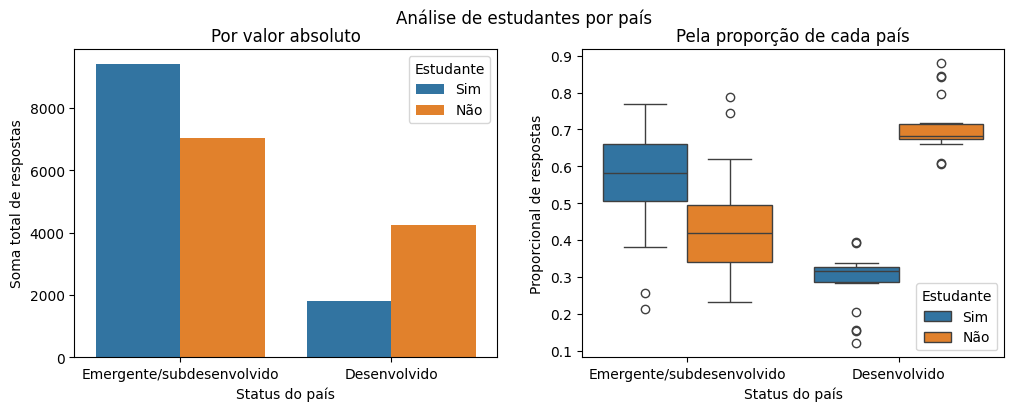

In [249]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

count = df.groupby('Q4')[['Q5']].value_counts().reset_index()
prop = df.groupby('Q4')[['Q5', 'Country-status']].value_counts(normalize=True).reset_index()

country_grouped = pd.merge(count,prop, on=['Q4', 'Q5']).rename(columns={'Q5': 'Estudante'})
country_grouped.replace({'Estudante': {'Yes': 'Sim', 'No': 'Não'},
                         'Country-status': {1: 'Emergente/subdesenvolvido', 2: 'Desenvolvido'}}, inplace=True)

sns.barplot(country_grouped, x='Country-status', y='count', hue='Estudante', ax=ax[0], estimator='sum', errorbar=None)
sns.boxplot(country_grouped, x='Country-status', y='proportion', hue='Estudante', ax=ax[1])

ax[0].set_xlabel('Status do país')
ax[0].set_ylabel('Soma total de respostas')
ax[0].set_title('Por valor absoluto')

ax[1].set_xlabel('Status do país')
ax[1].set_ylabel('Proporcional de respostas')
ax[1].set_title('Pela proporção de cada país')

plt.suptitle('Análise de estudantes por país')

#### Nível de escolaridade

O nível de escolaridade também aparenta mudar, com os desenvolvidos tendo mais estudantes a nível de mestrado, enquanto os subdesenvolvidos são focados na graduação.

<Axes: xlabel='Country-status', ylabel='proportion'>

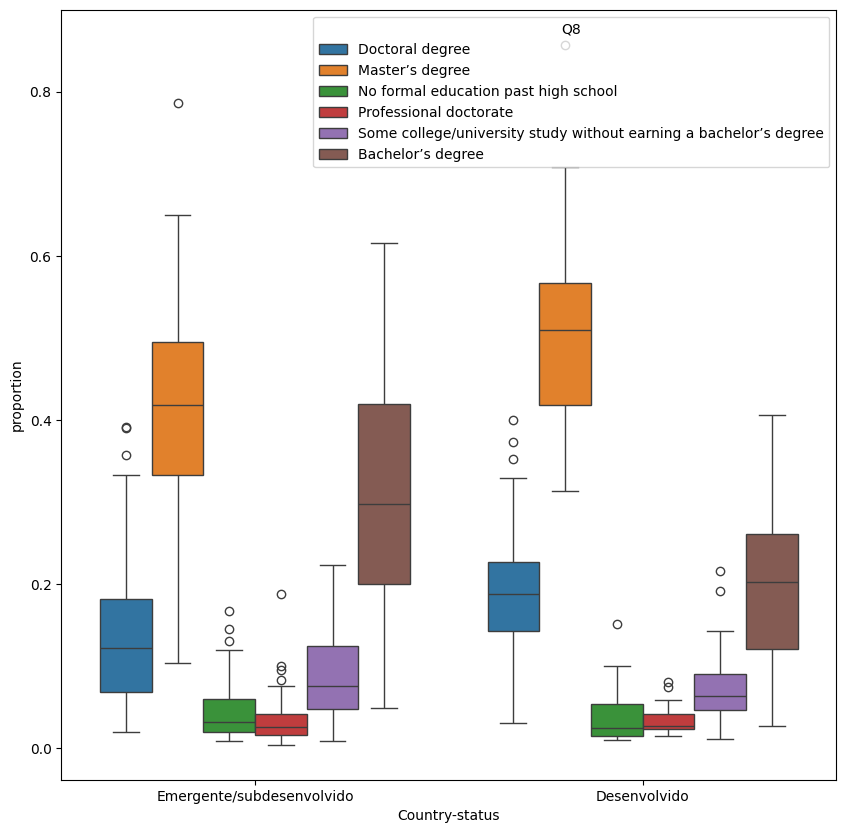

In [266]:
filtered = df[df['Q8'] != 'I prefer not to answer']
count = filtered.groupby(['Q4', 'Q5'])[['Q8']].value_counts().reset_index()
prop = filtered.groupby(['Q4', 'Q5'])[['Q8', 'Country-status']].value_counts(normalize=True).reset_index()

scholar_grouped = pd.merge(count,prop, on=['Q4', 'Q5', 'Q8']).rename(columns={'Q5': 'Estudante'})
scholar_grouped.replace({'Estudante': {'Yes': 'Sim', 'No': 'Não'},
                         'Country-status': {1: 'Emergente/subdesenvolvido', 2: 'Desenvolvido'}}, inplace=True)

fig,ax = plt.subplots(figsize=(10,10))
sns.boxplot(scholar_grouped, x='Country-status', y='proportion', hue='Q8', ax=ax)

### Anos de experiência

Os 

## Descoberta de subgrupos no mercado de trabalho de ML

Queremos descobrir subgrupos dentro daqueles empregados na área de ML, para podermos utilizar as questões relacionadas à indústria

In [251]:
employed = df[(df['Q5'] == 'No') & (df['Q23'] != 'Currently not employed')]
employed = filter_df(employed, ['Country-status', 'Q8', 'Q16', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q29', 'Q30']).dropna()
employed.head()

,Country-status,Q8,Q16,Q23,Q24,Q25,Q26,Q27,Q29,Q30
3,2,Some college/university study without earning ...,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","25,000-29,999","$1000-$9,999"
7,2,Bachelor’s degree,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...","100,000-124,999",$0 ($USD)
8,2,Doctoral degree,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...","100,000-124,999",$100-$999
13,2,Doctoral degree,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","200,000-249,999",$100-$999
16,2,Master’s degree,5-10 years,Data Scientist,Computers/Technology,"1000-9,999 employees",3-4,"We have well established ML methods (i.e., mod...","200,000-249,999","$100,000 or more ($USD)"


### Países desenvolvidos

Na maioria dos empregados, há uma forte tendência a usar métodos de ML estabelecidos, assim como altos salários e doutorados.

In [252]:
target = ps.BinaryTarget('Country-status', 2)
searchspace = ps.create_selectors(employed, ignore=['Country-status', 'Q4'])
task = ps.SubgroupDiscoveryTask (
    employed,
    target,
    searchspace,
    result_set_size=10,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

for x in result.to_dataframe()['subgroup']:
    print(x)
result.to_dataframe()

Q27=='We have well established ML methods (i.e., models in production for more than 2 years)'
Q29=='150,000-199,999'
Q16=='5-10 years'
Q8=='Doctoral degree'
Q29=='100,000-124,999'
Q26=='20+'
Q29=='125,000-149,999'
Q26=='20+' AND Q27=='We have well established ML methods (i.e., models in production for more than 2 years)'
Q27=='We have well established ML methods (i.e., models in production for more than 2 years)' AND Q8=='Doctoral degree'
Q16=='5-10 years' AND Q27=='We have well established ML methods (i.e., models in production for more than 2 years)'


,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.026755,Q27=='We have well established ML methods (i.e...,1516,6930,822,2910,5414,0.218759,0.781241,0.282474,0.717526,0.542216,0.385667,0.419913,1.291258
1,0.023825,"Q29=='150,000-199,999'",326,6930,302,2910,6604,0.047042,0.952958,0.103780,0.896220,0.926380,0.394912,0.419913,2.206122
2,0.023167,Q16=='5-10 years',756,6930,478,2910,6174,0.109091,0.890909,0.164261,0.835739,0.632275,0.393910,0.419913,1.505727
3,0.023071,Q8=='Doctoral degree',1191,6930,660,2910,5739,0.171861,0.828139,0.226804,0.773196,0.554156,0.392054,0.419913,1.319692
4,0.022611,"Q29=='100,000-124,999'",377,6930,315,2910,6553,0.054401,0.945599,0.108247,0.891753,0.835544,0.396002,0.419913,1.989800
5,0.018355,Q26=='20+',1838,6930,899,2910,5092,0.265224,0.734776,0.308935,0.691065,0.489119,0.394933,0.419913,1.164808
6,0.017691,"Q29=='125,000-149,999'",251,6930,228,2910,6679,0.036219,0.963781,0.078351,0.921649,0.908367,0.401557,0.419913,2.163223
7,0.016951,Q26=='20+' AND Q27=='We have well established ...,830,6930,466,2910,6100,0.119769,0.880231,0.160137,0.839863,0.561446,0.400656,0.419913,1.337051
8,0.016067,Q27=='We have well established ML methods (i.e...,304,6930,239,2910,6626,0.043867,0.956133,0.082131,0.917869,0.786184,0.403109,0.419913,1.872253
9,0.014420,Q16=='5-10 years' AND Q27=='We have well estab...,355,6930,249,2910,6575,0.051227,0.948773,0.085567,0.914433,0.701408,0.404715,0.419913,1.670364


### Países subdesenvolvidos

A maioria dos empregados é extremamente novo na área, não chegando a usar ML em seus trabalhos. Também há um destaque maior de graduandos, assim como o baixo gasto em serviços na nuvem.

In [253]:
target = ps.BinaryTarget('Country-status', 1)
searchspace = ps.create_selectors(employed, ignore=['Country-status', 'Q4'])
task = ps.SubgroupDiscoveryTask (
    employed,
    target,
    searchspace,
    result_set_size=10,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

for x in result.to_dataframe()['subgroup']:
    print(x)
result.to_dataframe()

Q29=='$0-999'
Q16=='Under 1 year'
Q27=='No (we do not use ML methods)'
Q8=='Bachelor’s degree'
Q29=='10,000-14,999'
Q29=='1,000-1,999'
Q30=='$1-$99'
Q29=='$0-999' AND Q30=='$0 ($USD)'
Q16=='Under 1 year' AND Q8=='Master’s degree'
Q23=='Data Analyst (Business, Marketing, Financial, Quantitative, etc)'


,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.033741,Q29=='$0-999',845,6930,724,4020,6085,0.121934,0.878066,0.180100,0.819900,0.856805,0.541660,0.580087,1.477029
1,0.029437,Q16=='Under 1 year',1617,6930,1142,4020,5313,0.233333,0.766667,0.284080,0.715920,0.706246,0.541690,0.580087,1.217484
2,0.022080,Q27=='No (we do not use ML methods)',1417,6930,975,4020,5513,0.204473,0.795527,0.242537,0.757463,0.688073,0.552331,0.580087,1.186156
3,0.021361,Q8=='Bachelor’s degree',1679,6930,1122,4020,5251,0.242280,0.757720,0.279104,0.720896,0.668255,0.551895,0.580087,1.151992
4,0.020878,"Q29=='10,000-14,999'",416,6930,386,4020,6514,0.060029,0.939971,0.096020,0.903980,0.927885,0.557875,0.580087,1.599562
5,0.018685,"Q29=='1,000-1,999'",356,6930,336,4020,6574,0.051371,0.948629,0.083582,0.916418,0.943820,0.560389,0.580087,1.627033
6,0.018678,Q30=='$1-$99',1187,6930,818,4020,5743,0.171284,0.828716,0.203483,0.796517,0.689132,0.557548,0.580087,1.187982
7,0.016174,Q29=='$0-999' AND Q30=='$0 ($USD)',386,6930,336,4020,6544,0.055700,0.944300,0.083582,0.916418,0.870466,0.562958,0.580087,1.500580
8,0.015255,Q16=='Under 1 year' AND Q8=='Master’s degree',709,6930,517,4020,6221,0.102309,0.897691,0.128607,0.871393,0.729196,0.563093,0.580087,1.257047
9,0.015092,"Q23=='Data Analyst (Business, Marketing, Finan...",1104,6930,745,4020,5826,0.159307,0.840693,0.185323,0.814677,0.674819,0.562135,0.580087,1.163307


In [254]:
employed['Q3'] = df['Q3']
emerging = ps.EqualitySelector('Country-status', 1)
woman = ps.EqualitySelector('Q3', 'Woman')

target = ps.BinaryTarget(target_selector = ps.Conjunction([emerging, woman]))
searchspace = ps.create_selectors(employed, ignore=['Country-status', 'Q3'])

task = ps.SubgroupDiscoveryTask (
    employed,
    target,
    searchspace,
    result_set_size=5,
    depth=4,
    qf=ps.WRAccQF())

result = ps.BeamSearch().execute(task)
result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.016948,Q29=='$0-999',845,6930,200,677,6085,0.121934,0.878066,0.295421,0.704579,0.236686,0.078389,0.097691,2.422802
1,0.011694,Q23=='Teacher / professor',624,6930,142,677,6306,0.090043,0.909957,0.209749,0.790251,0.227564,0.084840,0.097691,2.329423
2,0.011404,Q24=='Academics/Education',1095,6930,186,677,5835,0.158009,0.841991,0.274742,0.725258,0.169863,0.084147,0.097691,1.738775
3,0.009549,Q23=='Teacher / professor' AND Q24=='Academics...,551,6930,120,677,6379,0.079509,0.920491,0.177253,0.822747,0.217786,0.087318,0.097691,2.229329
4,0.007834,Q29=='$0-999' AND Q30=='$0 ($USD)',386,6930,92,677,6544,0.055700,0.944300,0.135894,0.864106,0.238342,0.089395,0.097691,2.439749
